# Imports


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import os
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from general import GeneralUtil as util

## Constants


In [2]:
# Set the classes
classes = ("A", "B", "C", "D", "E")
# GPU Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Labels
labels = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
}

ROOT_DIR = "/content"
TESTING_PATH = "/content/test/"

# Homebrewed Functions & Model Architecture


In [3]:
class ASL_CNN(nn.Module):
    def __init__(self, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()

        self.features = nn.Sequential(
            # Conv1 https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  #  15x15
            # Conv3
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  #  7x7
        )
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        # average pooling, just specify output size
        # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),  # p = dropout probability
            nn.Linear(256 * 3 * 3, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

        # initialize the weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Based on our previous discussion, we should initialize the convolutions according to the activation function
                # Fan-out focuses on the gradient distribution,
                # and is commonly used
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [4]:
def display_sample_image(imageloader, n=1):
    """Display a sample of the images in the given image loader"""
    plt.rcParams["figure.figsize"] = (10, 10)

    def _imshow(img):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    for _ in range(n):
        # get some random images
        dataiter = iter(imageloader)
        images, labels = next(dataiter)

        # show images
        _imshow(torchvision.utils.make_grid(images))
        # print labels
        print(" ".join("%12s" % classes[labels[j]] for j in range(len(images))))


def plot_acc_loss(train_accs, test_accs, train_losses, test_losses, caption):
    """Plot the accuracy and loss"""
    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_accs, label="Train")
    plt.plot(test_accs, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Classification Accuracy vs Epoch: {}".format(caption))

    # Visualize the loss / acc
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(test_losses, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Cross Entropy Loss")
    plt.legend()
    plt.title("Cross Entropy Loss vs Epoch: {}".format(caption))

    return


def plot_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def train(device=torch.device("cpu"), scheduler=None):
    """Function to train the model"""
    net.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Calcualte accuracy
        _, predicted = torch.max(outputs.data.detach().cpu(), 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()

    training_loss.append(running_loss / i)
    training_acc.append(100.0 * correct / total)

    return running_loss


def validation(val_loader, device=torch.device("cpu"), verbose=False):
    pred = []
    file_name = []

    net.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images.to(device))

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data.detach().cpu(), 1)
            fname, _ = test_loader.dataset.samples[i]
            file_name.append(fname.split("/")[-1])
            pred.append(predicted.item())

    results = pd.DataFrame(
        zip(file_name, pred), columns=["Filename", "Predicted_label"]
    )
    return results


def save_model(net, PATH=f"{ROOT_DIR}/models/", name="asl_cnn.pth"):
    """Function to save the model"""
    torch.save(net.state_dict(), PATH + name)


def load_data(test_path, batch_size=32):
    # --------------------------------------------------------------------------------------------------
    # Set up transformer to normalize and transform the data
    # --------------------------------------------------------------------------------------------------
    test_transform = transforms.Compose(
        [
            # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
            transforms.RandomResizedCrop((42, 42), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            # https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # --------------------------------------------------------------------------------------------------
    # Create the training and test datasets as well as the data loaders
    # --------------------------------------------------------------------------------------------------
    # Data Sets
    test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

    # Data Loaders
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=2,
    )
    print(f"Successfully loaded images\nBatch size: {batch_size}")
    return test_loader

# Download Test Images


In [5]:
%%capture
!pip install --upgrade --no-cache-dir gdown

# Prepare dir
!mkdir -p /content/test/

# Download
!gdown --id 1rMWWzFMbsZabF3VJq48wyZVLWxgwO8jg --output "/content/test/test.zip"

# Unzip
!unzip /content/test/test.zip -d /content/test

# Remove MACOSX
!rm -rf /content/test/__MACOSX

# Download Model


In [6]:
# Fetch
!wget https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/models/sgd_wd_tuned_asl_cnn.pth -O best_model.pth

--2022-12-20 18:02:34--  https://github.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/raw/main/models/sgd_wd_tuned_asl_cnn.pth
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/models/sgd_wd_tuned_asl_cnn.pth [following]
--2022-12-20 18:02:35--  https://raw.githubusercontent.com/RumiAllbert/American-Sign-Language-Recogniztion-CNN/main/models/sgd_wd_tuned_asl_cnn.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16696148 (16M) [application/octet-stream]
Saving to: ‘best_model.pth’

best_model.pth      100%[===================>]  1

# Testing


## Load Images


In [7]:
test_loader = load_data(TESTING_PATH, batch_size=1)


Successfully loaded images
Batch size: 1


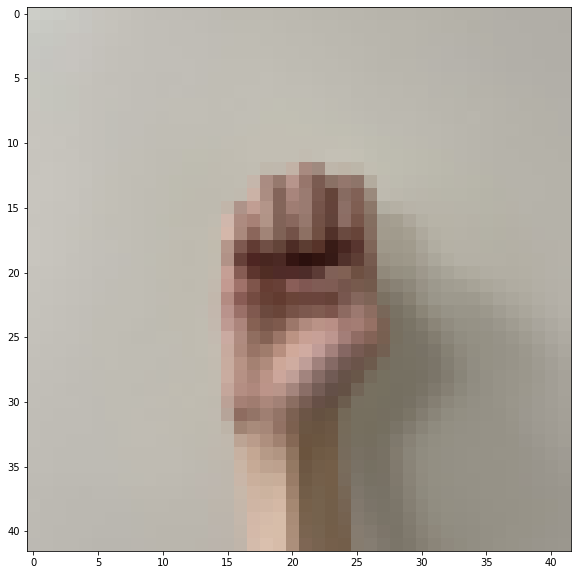

           A


In [8]:
display_sample_image(test_loader)


## Load Model


In [9]:
PATH = f"{ROOT_DIR}/best_model.pth"

net = ASL_CNN(num_classes=5, dropout=0.1)

net.load_state_dict(torch.load(PATH, map_location=torch.device("cpu")))
net.to(device)

ASL_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=2304, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
  

## Predict


In [10]:
predicted = validation(test_loader, device=device)
predicted["Predicted_label"] = predicted["Predicted_label"].map(labels)
predicted

,Filename,Predicted_label
0,000371fe7f6a5911f6c2.jpg,E
1,00134e2d69c6daaf73bd.jpg,D
2,0022efa0be0bca9e1021.jpg,E
3,005ea83dd7a00797b7f8.jpg,E
4,005f57608dcae82c3b68.jpg,A
...,...,...
1780,ff12d4c6566505beff00.jpg,A
1781,ff8b385769f161779030.jpg,A
1782,ffb69d75404c81170f60.jpg,D
1783,ffc2ace04b58e3108b55.jpg,A


# Export Results


In [11]:
predicted.to_csv("result.csv", index=False)